# Data Analysis

Performing some statistical analysis with the goal of seeing if there are any correlations between chosen key demographics: Poverty Rates and Income levels; and chosen measures of Restaurant popularity: Yelp Ratings and Review Count, Performed by Tiffany Cheng

HA: If a zip code is classified to have higher income levels/lower poverty rates, there is a greater likelihood that a fast food restaurant located in the same zip code will have a higher Yelp Rating or higher Review count.

H0: Based on the Food52 Fast Food Restaurant dataset, there is no correlation between income levels/poverty rates and ratings and review counts of Fast food Restaurants

#### Things to consider: 

- What defines popularity? Ratings? # of restaurants in focus region/states/etc? # of Reviews?
- Is there a correlation between Poverty Rates and Income level to higher Yelp Ratings and Review Counts?

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import gmaps

import seaborn as sns

In [4]:
# Importing Census data
zipmerge_path = "Resources/zipmerge_df.csv"

zipmerge_data = pd.read_csv(zipmerge_path)
zipmerge_data.head()

,Zipcode,Latitude,Longitude,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Income Levels
0,55795,46.317812,-92.84315,1753.0,40.8,50063.0,21922.0,191.0,10.895608,"Middle(<95,000)"
1,45388,40.328535,-84.47938,946.0,32.2,96940.0,36923.0,7.0,0.739958,"High(<400,000)"
2,39483,31.218509,-89.90761,6122.0,41.4,29726.0,24034.0,1696.0,27.703365,"Low(<35,000)"
3,31503,31.205194,-82.37534,20344.0,41.8,40981.0,21426.0,4748.0,23.338576,"Middle(<95,000)"
4,45833,40.841409,-84.34178,10667.0,42.5,61545.0,29317.0,745.0,6.984157,"Middle(<95,000)"


In [5]:
# Importing Fast Food + Yelp Info data + cleanup
yelp_path = "Resources/yelp_data_clean.csv"
yelp_data = pd.read_csv(yelp_path)

yelp_data = yelp_data[["name","categories","address","city","postalCode","state","country","latitude","longitude","count","Rating","Review Count","Closed"]]
yelp_data = yelp_data.replace({"Chick-Fil-A":"Chick-fil-A","McDonalds":"McDonald's"})
yelp_data["Zipcode"] = [x[:5] for x in yelp_data["postalCode"]]
yelp_data["Zipcode"] = pd.to_numeric(yelp_data["Zipcode"] , downcast="float")
yelp_data.head()

,name,categories,address,city,postalCode,state,country,latitude,longitude,count,Rating,Review Count,Closed,Zipcode
0,Carl's Jr.,"Fast Food Restaurants,Hamburgers and Hot Dogs,...",2555 11th Avenue,Greeley,80631,Colorado,US,40.39629,-104.69699,205,2.5,6.0,False,80631.0
1,Del Taco,"Restaurant,Mexican Restaurants,Fast Food Resta...",2513 Highway 6 And 50,Grand Junction,81505,Colorado,US,39.08135,-108.58689,30,3.5,6.0,False,81505.0
2,Chipotle Mexican Grill,"Fast Food Restaurants,Mexican Restaurants,Rest...",3455 N Salida Court,Aurora,80011,Colorado,US,39.76369,-104.77671,142,3.0,43.0,False,80011.0
3,Taco Bell,"Fast Food Restaurants,Mexican Restaurants,Rest...",5225 E Colfax Avenue,Denver,80220,Colorado,US,39.74044,-104.92636,529,2.0,40.0,False,80220.0
4,McDonald's,"Fast Food Restaurants,Hamburgers and Hot Dogs,...",1350 W Colfax Avenue,Denver,80204,Colorado,US,39.73967,-105.00467,784,2.0,56.0,False,80204.0


In [26]:
# Merging Census Data and Yelp + Food Data
census_fastfood = pd.merge(left=yelp_data, right=zipmerge_data, left_on='Zipcode', right_on='Zipcode', how='left')
census_fastfood = census_fastfood[["name","state","city","Zipcode","Rating","Review Count","Household Income","Per Capita Income","Poverty Rate","Income Levels"]]

census_fastfood.head()

,name,state,city,Zipcode,Rating,Review Count,Household Income,Per Capita Income,Poverty Rate,Income Levels
0,Carl's Jr.,Colorado,Greeley,80631.0,2.5,6.0,44097.0,19977.0,21.805198,"Middle(<95,000)"
1,Del Taco,Colorado,Grand Junction,81505.0,3.5,6.0,65181.0,37213.0,12.425866,"Middle(<95,000)"
2,Chipotle Mexican Grill,Colorado,Aurora,80011.0,3.0,43.0,51461.0,21913.0,13.854175,"Middle(<95,000)"
3,Taco Bell,Colorado,Denver,80220.0,2.0,40.0,82642.0,57515.0,9.672998,"Middle(<95,000)"
4,McDonald's,Colorado,Denver,80204.0,2.0,56.0,50429.0,31480.0,25.809580,"Middle(<95,000)"


### Testing for Correlations:

Yelp Ratings vs. Per Capita Income

In [122]:
# Plot Box Pot of Per Capita Income to Yelp Ratings

# Put treatments into a list for for loop (and later for plot labels)
yelp_ratings = [1,2,3,4,5]

# Create empty list to fill with tumor vol data (for plotting)
income_list = []
income_outliers = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for rating in yelp_ratings:
    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    rating_subset = census_fastfood.loc[(census_fastfood["Rating"] == rating) & (census_fastfood["Per Capita Income"].notnull()), "Per Capita Income"]
    # print(rating_subset)
    # add subset 
    income_list.append(rating_subset)
    
    # Determine outliers using upper and lower bounds
    
    quartiles = rating_subset.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    
    # Create outlier_subset list to look for outliers outside of quartile bounds and print results
    outlier_subset = census_fastfood.loc[(census_fastfood["Rating"] == rating) & ((census_fastfood["Per Capita Income"] > upper_bound)|(census_fastfood["Per Capita Income"]  < lower_bound)) , "Per Capita Income"]
    
    # print(f"{rating}'s' potential outliers: {outlier_subset}")
    
    print(f"{rating}'s average Income Per Capita is {quartiles[0.5]}")

1's average Income Per Capita is 26166.0
2's average Income Per Capita is 29192.0
3's average Income Per Capita is 29730.5
4's average Income Per Capita is 29239.0
5's average Income Per Capita is 26335.0


In [162]:
# Calculate Average Income Per Capita for lower Yelp Rating (1 and 2)
avglowrank = (26166+29192)/2
print(avglowrank)
# Calculate Average Income Per Capita for lower Yelp Rating (1 and 2)
avghighrank = (29239+26335)/2
print(avghighrank)

27679.0
27787.0


<ipython-input-123-81374bcea53a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(yelp_ratings)


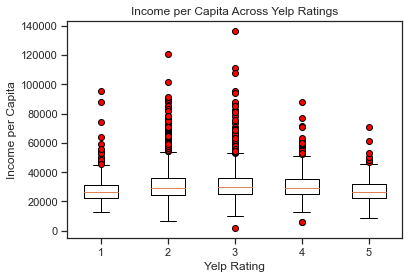

In [123]:
# Plot Box Plot of Poverty Rates to Yelp Ratings

fig1, ax1 = plt.subplots()
ax1.set_title('Income per Capita Across Yelp Ratings')
ax1.set_ylabel('Income per Capita')
ax1.set_xlabel('Yelp Rating')
ax1.set_xticklabels(yelp_ratings)
ax1.set
flierprops = dict(marker='.', markerfacecolor='red', markersize=12.0)
plt.boxplot(income_list,flierprops=flierprops)
plt.show()

Text(0.5, 1.0, 'Per Capita Income vs. Yelp Rating')

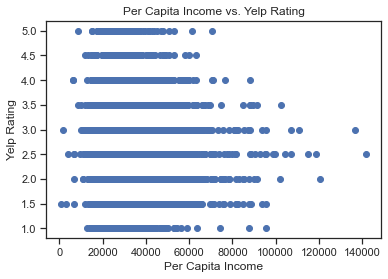

In [124]:
plt.scatter(census_fastfood["Per Capita Income"],census_fastfood["Rating"])
plt.xlabel("Per Capita Income")
plt.ylabel("Yelp Rating")
plt.title("Per Capita Income vs. Yelp Rating")

#### Observation: 
Noticing that there is most likely not a significant correlation between Ratings and Income per Capita as the Income Per Capita seems pretty equally distributed amongst Yelp Ratings

### Testing for Correlation:

Review Count v. Per Capita Income

Text(0.5, 1.0, 'Per Capita Income vs. Review Count')

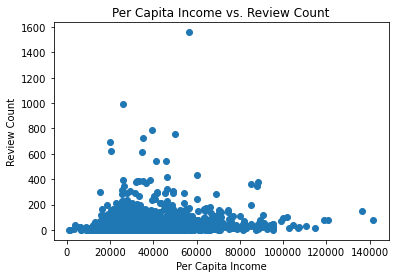

In [7]:
# Plotting Per Capita Income versus Review Count
plt.scatter(census_fastfood["Per Capita Income"],census_fastfood["Review Count"])
plt.xlabel("Per Capita Income")
plt.ylabel("Review Count")
plt.title("Per Capita Income vs. Review Count")

In [8]:
# Calculating means based on Census data's Income Level categorization to use to perform Significance tests

highincome = census_fastfood.loc[census_fastfood["Income Levels"] == "High(<400,000)"]
medincome = census_fastfood.loc[census_fastfood["Income Levels"] == "Middle(<95,000)"]
lowincome = census_fastfood.loc[census_fastfood["Income Levels"] == "Low(<35,000)"]

highincome_mean = highincome["Rating"].mean()
medincome_mean = medincome["Rating"].mean()
lowincome_mean = lowincome["Rating"].mean()

print(highincome_mean)
print(medincome_mean)
print(lowincome_mean)

2.5213310580204777
2.532181168057211
2.4533029612756265


In [127]:
# Calculate Independent (Two Sample) t-test between high and medium income level
st.ttest_ind(highincome["Rating"],medincome["Rating"], equal_var=False)

Ttest_indResult(statistic=-0.3212705015391367, pvalue=0.7480959047364919)

In [128]:
# Calculate Independent (Two Sample) t-test between high and low income level
st.ttest_ind(highincome["Rating"],lowincome["Rating"], equal_var=False)

Ttest_indResult(statistic=1.1465431167037723, pvalue=0.25192709316046547)

In [129]:
# Calculate Independent (Two Sample) t-test between low and medium income level
st.ttest_ind(medincome["Rating"],lowincome["Rating"], equal_var=False)

Ttest_indResult(statistic=1.5361354745674378, pvalue=0.12515871021342395)

#### Observation:

Considering p-values, our null hypothesis that there is no correlation between income levels and Ratings

### Testing for Correlation:

Yelp Ratings v. Poverty Rate

In [10]:
# Binning the Poverty Rate to Low, Medium, High by the range of 0 to 8, 8 to 15, and greater than 15.

print(census_fastfood["Poverty Rate"].min())
print(census_fastfood["Poverty Rate"].max())
print(census_fastfood["Poverty Rate"].mean())

quartiles = census_fastfood["Poverty Rate"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of poverty rate is: {lowerq}")
print(f"The upper quartile of poverty rate is: {upperq}")
print(f"The interquartile range of poverty rate is: {iqr}")
print(f"The the median of poverty rate is: {quartiles[0.5]} ")

0.0
57.381193124368046
14.067361438688787
The lower quartile of poverty rate is: 8.422455094205382
The upper quartile of poverty rate is: 18.391468725458623
The interquartile range of poverty rate is: 9.96901363125324
The the median of poverty rate is: 12.854670372895576 


In [11]:
bins = [0,lowerq,upperq,60]
poverty_lvls = ["low","medium","high"]

census_fastfood["PovertyLvl"] = pd.cut(census_fastfood["Poverty Rate"], bins, labels=poverty_lvls, include_lowest=True)
census_fastfood.head()

,name,state,Zipcode,Rating,Review Count,Household Income,Per Capita Income,Poverty Rate,Income Levels,PovertyLvl
0,Carl's Jr.,Colorado,80631.0,2.5,6.0,44097.0,19977.0,21.805198,"Middle(<95,000)",high
1,Del Taco,Colorado,81505.0,3.5,6.0,65181.0,37213.0,12.425866,"Middle(<95,000)",medium
2,Chipotle Mexican Grill,Colorado,80011.0,3.0,43.0,51461.0,21913.0,13.854175,"Middle(<95,000)",medium
3,Taco Bell,Colorado,80220.0,2.0,40.0,82642.0,57515.0,9.672998,"Middle(<95,000)",medium
4,McDonald's,Colorado,80204.0,2.0,56.0,50429.0,31480.0,25.809580,"Middle(<95,000)",high


In [12]:
highpov_yelp = census_fastfood.loc[census_fastfood["PovertyLvl"] == "high"]
medpov_yelp = census_fastfood.loc[census_fastfood["PovertyLvl"] == "medium"]
lowpov_yelp = census_fastfood.loc[census_fastfood["PovertyLvl"] == "low"]

highpov_mean = highpov_yelp["Rating"].mean()
lowpov_mean = medpov_yelp["Rating"].mean()
medpov_mean = lowpov_yelp["Rating"].mean()

print(highpov_mean)
print(lowpov_mean)
print(medpov_mean)

2.475232198142415
2.533161290322581
2.5652734778121773


In [15]:
# Put treatments into a list for for loop (and later for plot labels)
yelp_ratings = [1,2,3,4,5]

# Create empty list to fill with tumor vol data (for plotting)
povertyrates_list = []
povertyrates_outliers = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for rating in yelp_ratings:
    
    rating_subset = census_fastfood.loc[(census_fastfood["Rating"] == rating) & (census_fastfood["Poverty Rate"].notnull()), "Poverty Rate"] 
    povertyrates_list.append(rating_subset)
    
    # Determine outliers using upper and lower bounds
    
    quartiles = rating_subset.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    
    # Create outlier_subset list to look for outliers outside of quartile bounds and print results
    outlier_subset = census_fastfood.loc[(census_fastfood["Rating"] == rating) & ((census_fastfood["Poverty Rate"] > upper_bound)|(census_fastfood["Poverty Rate"]  < lower_bound)) , "Poverty Rate"]
    
    # print(f"{rating}'s' potential outliers: {outlier_subset}")
    
    print(f"{rating}'s average poverty rate is {quartiles[0.5]}")

1's average poverty rate is 15.258215962441314
2's average poverty rate is 12.532075159341113
3's average poverty rate is 12.326059098433195
4's average poverty rate is 12.649991549771846
5's average poverty rate is 15.357895336256476


Text(0.5, 1.0, 'Fast Food Restaurant Ratings vs. Poverty Rates in US')

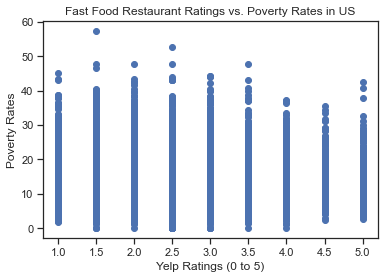

In [13]:
plt.scatter(census_fastfood["Rating"],census_fastfood["Poverty Rate"])
plt.xlabel("Yelp Ratings (0 to 5)")
plt.ylabel("Poverty Rates")
plt.title("Fast Food Restaurant Ratings vs. Poverty Rates in US")

<ipython-input-16-5e0661a7f06e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(yelp_ratings)


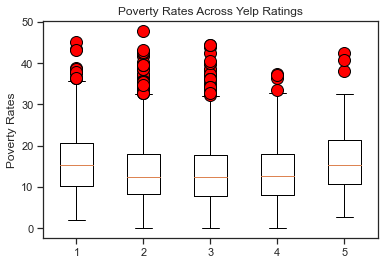

In [16]:
# Plot Box Plot of Poverty Rates to Yelp Ratings

fig1, ax1 = plt.subplots()
ax1.set_title('Poverty Rates Across Yelp Ratings')
ax1.set_ylabel('Poverty Rates')
ax1.set_xticklabels(yelp_ratings)
ax1.set
flierprops = dict(marker='o', markerfacecolor='red', markersize=12.0)
plt.boxplot(povertyrates_list,flierprops=flierprops)
plt.show()

#### Observations:

From the Boxplot, pretty equal distribution amongst Yelp Ratings and Poverty Rates similarly to with Per Capita Income. Maybe take a more honed approach and look at specific cities?

In [27]:
# Further Analysis within California

ca_census_yelp = census_fastfood.loc[census_fastfood["state"] == "California"]

In [28]:
# Binning the Poverty Rate to Low, Medium, High by the range of 0 to 8, 8 to 15, and greater than 15.
# According to the US Census Bureau, the lowest poverty rate was 4.9% and the highest poverty rate was 19.4%
# Hence the bins were created based off of this range.

print(ca_census_yelp["Poverty Rate"].min())
print(ca_census_yelp["Poverty Rate"].max())
print(ca_census_yelp["Poverty Rate"].mean())

quartiles = ca_census_yelp["Poverty Rate"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of poverty rate is: {lowerq}")
print(f"The upper quartile of poverty rate is: {upperq}")
print(f"The interquartile range of poverty rate is: {iqr}")
print(f"The the median of poverty rate is: {quartiles[0.5]} ")

2.918838900688679
40.361986174872044
13.414707885436439
The lower quartile of poverty rate is: 7.861159767282956
The upper quartile of poverty rate is: 17.982980258459737
The interquartile range of poverty rate is: 10.12182049117678
The the median of poverty rate is: 11.96637887225647 


In [29]:
bins = [0,lowerq,upperq,60]
ca_poverty_lvls = ["low","medium","high"]

# get a high poverty city in CA: Bakersfield
ca_census_yelp["PovertyLvl"] = pd.cut(ca_census_yelp["Poverty Rate"], bins, labels=ca_poverty_lvls, include_lowest=True)
ca_census_yelp = ca_census_yelp.sort_values(by="Poverty Rate",ascending = False)

<ipython-input-29-602c88f24699>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_census_yelp["PovertyLvl"] = pd.cut(ca_census_yelp["Poverty Rate"], bins, labels=ca_poverty_lvls, include_lowest=True)


In [31]:
# Get a low poverty city: San Jose
ca_census_yelp = ca_census_yelp.sort_values(by="Poverty Rate",ascending = True)

In [33]:
# Analysis on a state of higher poverty rate: Bakersfield

bk_census_yelp = ca_census_yelp.loc[ca_census_yelp["city"] == "Bakersfield"]
highpov_bk_mean = bk_census_yelp["Rating"].mean()
print(highpov_bk_mean)

# Analysis on a state of higher poverty rate: San Jose

sj_census_yelp = ca_census_yelp.loc[ca_census_yelp["city"] == "San Jose"]
highpov_sj_mean = sj_census_yelp["Rating"].mean()
print(highpov_sj_mean)

2.2083333333333335
2.46875


In [34]:
# Calculate Independent (Two Sample) t-test between high poverty and medium poverty level
st.ttest_ind(bk_census_yelp["Rating"],sj_census_yelp["Rating"], equal_var=False)

Ttest_indResult(statistic=-1.8246648569672173, pvalue=0.07657745390357791)

#### Observation:

Honing down to specific cities seem to show higher evidence of potential significant difference between states of lower to higher poverty levels, but not enough to reject null hypothesis

### Testing Correlation:

Review Count v. Poverty Rates

Text(0.5, 1.0, 'Poverty Rate vs. Review Count')

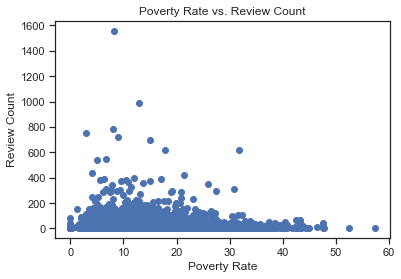

In [130]:
plt.scatter(census_fastfood["Poverty Rate"],census_fastfood["Review Count"])
plt.xlabel("Poverty Rate")
plt.ylabel("Review Count")
plt.title("Poverty Rate vs. Review Count")

The correlation between # of fast Food Restaurants and the state average poverty rate is nan


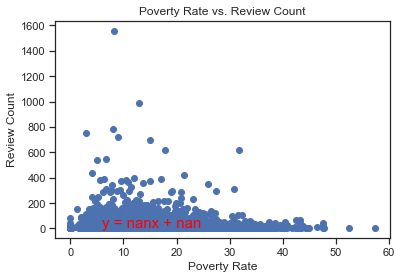

The Standard Error for our Regression Line is nan


In [131]:
# Calculate the correlation coefficient and linear regression model 

x_values = census_fastfood["Poverty Rate"]
y_values = census_fastfood["Review Count"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f'The correlation between # of fast Food Restaurants and the state average poverty rate is {"{:.3f}".format(rvalue)}')

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel("Poverty Rate")
plt.ylabel("Review Count")
plt.title("Poverty Rate vs. Review Count")
plt.show()

print(f'The Standard Error for our Regression Line is {stderr}')

#### Observation:

Scatter plots and lack of linear regression further supports the null hypothesis

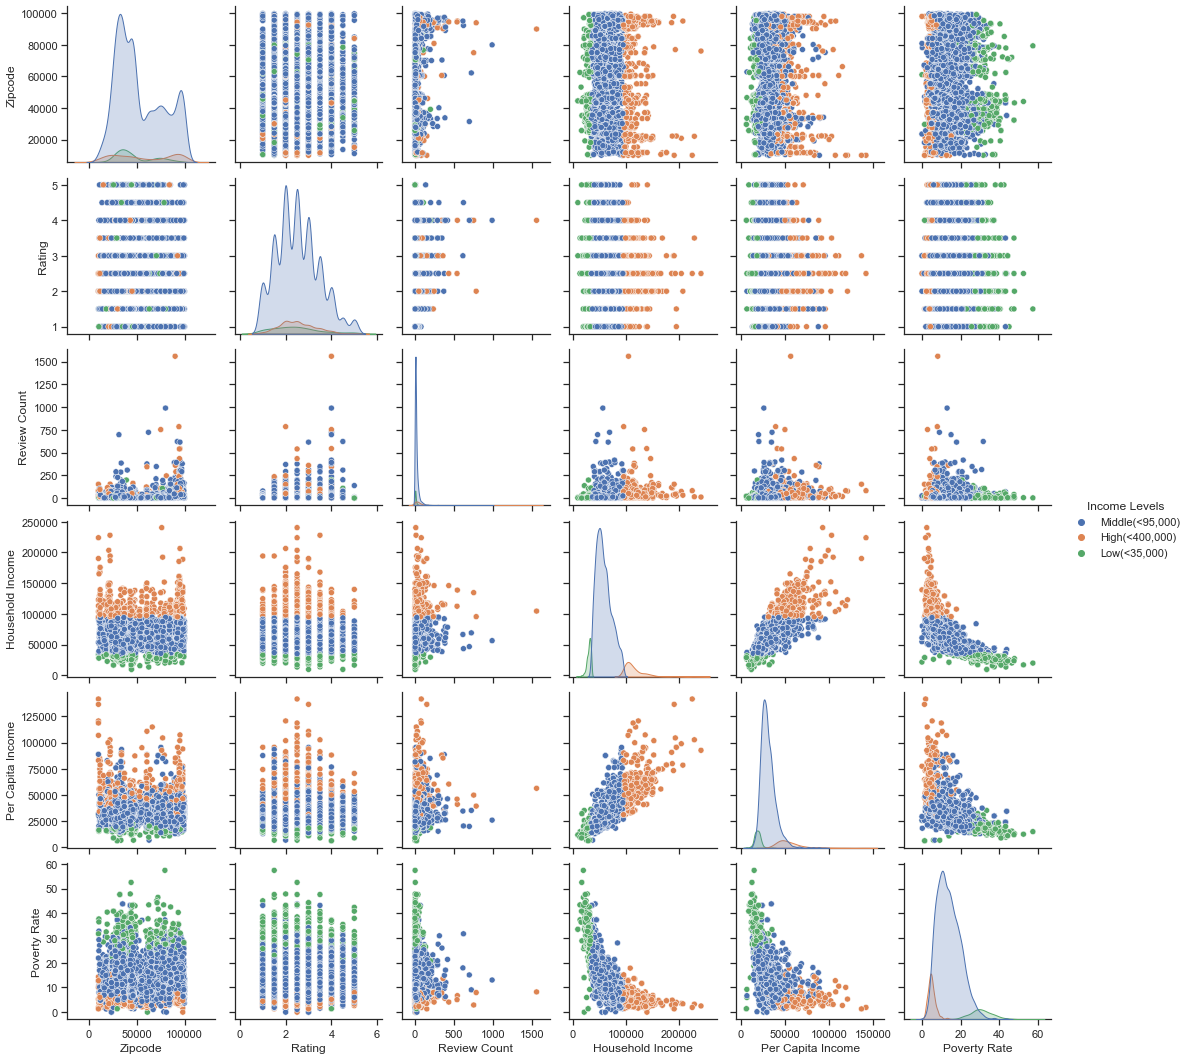

In [9]:
# Data Exploration of Plot Matrix to see if there are any noticeable correlations or observations to note when applying
# categorizations of Income Levels

sns.set_theme(style="ticks")
sns.pairplot(census_fastfood, hue="Income Levels")

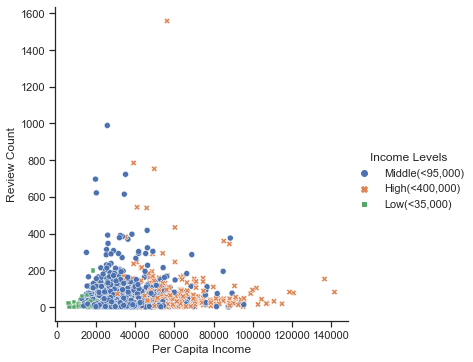

In [141]:
sns.relplot(x = "Per Capita Income" , y = "Review Count", style = "Income Levels", hue = "Income Levels",data=stat_df);

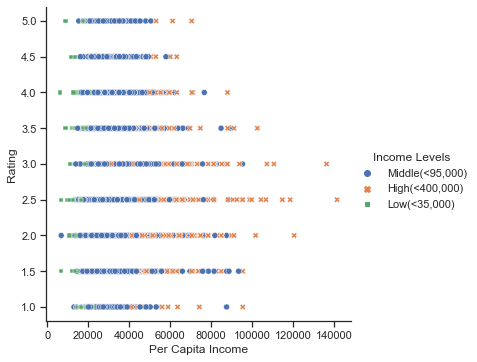

In [142]:
sns.relplot(x = "Per Capita Income" , y = "Rating", style = "Income Levels", hue = "Income Levels",data=stat_df);

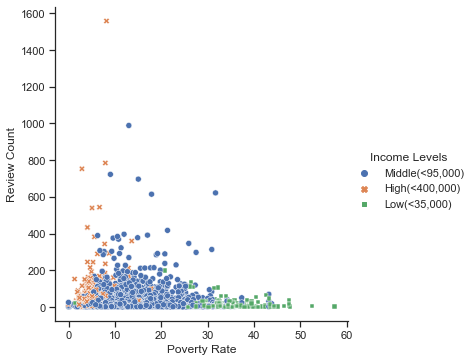

In [143]:
sns.relplot(x = "Poverty Rate" , y = "Review Count", style = "Income Levels", hue = "Income Levels",data=stat_df);

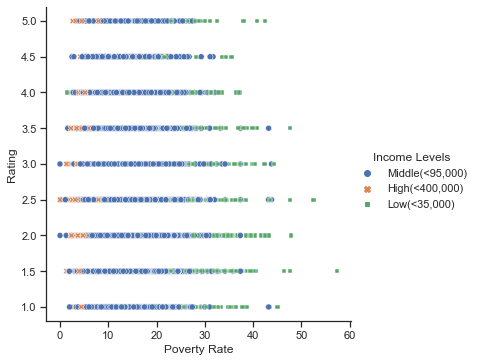

In [144]:
sns.relplot(x = "Poverty Rate" , y = "Rating", style = "Income Levels", hue = "Income Levels",data=stat_df);

In [146]:
# Binning the Poverty Rate to Low, Medium, High by the range of 0 to 8, 8 to 15, and greater than 15.

print(census_fastfood["Poverty Rate"].min())
print(census_fastfood["Poverty Rate"].max())
print(census_fastfood["Poverty Rate"].mean())

quartiles = census_fastfood["Poverty Rate"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of poverty rate is: {lowerq}")
print(f"The upper quartile of poverty rate is: {upperq}")
print(f"The interquartile range of poverty rate is: {iqr}")
print(f"The the median of poverty rate is: {quartiles[0.5]} ")

0.0
57.381193124368046
14.067361438688787
The lower quartile of poverty rate is: 8.422455094205382
The upper quartile of poverty rate is: 18.391468725458623
The interquartile range of poverty rate is: 9.96901363125324
The the median of poverty rate is: 12.854670372895576 


In [148]:
bins = [0,lowerq,upperq,60]
poverty_lvls = ["Low(<8.4%)","Middle(<18.39%)","High(>18.39%)"]

census_fastfood["Poverty Levels"] = pd.cut(census_fastfood["Poverty Rate"], bins, labels=poverty_lvls, include_lowest=True)
povstat_df = census_fastfood[["Rating","Review Count","Per Capita Income","Poverty Rate","Poverty Levels"]]

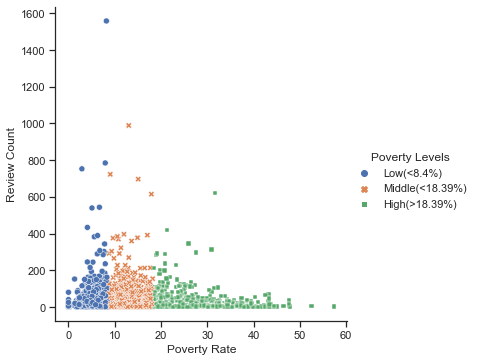

In [150]:
sns.relplot(x = "Poverty Rate" , y = "Review Count", style = "Poverty Levels", hue = "Poverty Levels",data=povstat_df);

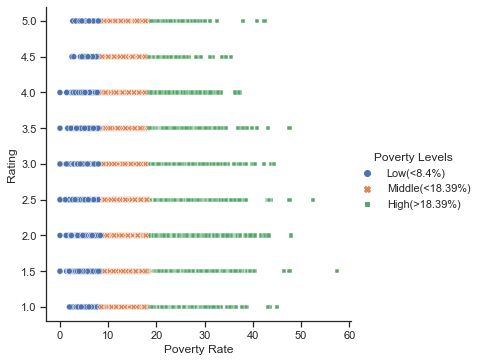

In [151]:
sns.relplot(x = "Poverty Rate" , y = "Rating", style = "Poverty Levels", hue = "Poverty Levels",data=povstat_df);

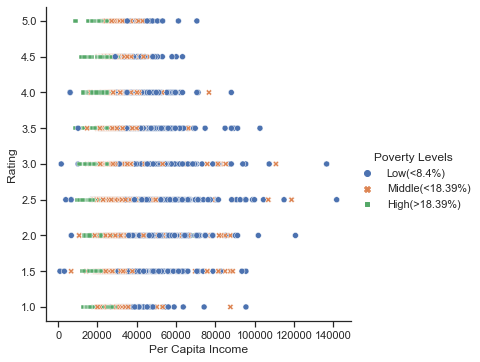

In [154]:
sns.relplot(x = "Per Capita Income" , y = "Rating", style = "Poverty Levels", hue = "Poverty Levels",data=povstat_df);

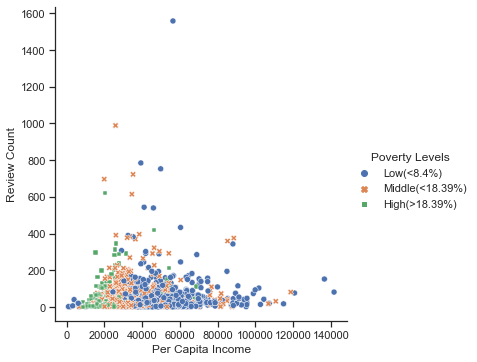

In [156]:
sns.relplot(x = "Per Capita Income" , y = "Review Count", style = "Poverty Levels", hue = "Poverty Levels",data=povstat_df);

### Closing Observations and Trends:

Though our null hypothesis was true and there is no statistically significant correlation between our selected demographics and measures of popularity, we can still observe that many of the fast food restaurants with the highest review counts or ratings come from zip codes recorded to have low to middle poverty rates and high to medium income levels